In [25]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
%matplotlib inline
from matplotlib.colors import LogNorm
from matplotlib import rcParams

import pickle
import glob
from konsta_cta.reco import LookupGenerator

In [2]:
output_dir = "/Users/konstantinpfrang/ctaout/"

In [3]:
def calc_angular_resolution(off_angle, trueE, q=0.68, erange=[0.01, 100], bins=10):
    '''
    off_angle - pd.Series
    true_e - pd.Series
    quantile - float
    erange - list, upper an lower edge in TeV
    ebins - int, number of bins
    '''

    ebins_log = np.linspace(np.log10(erange[0]), np.log10(erange[1]), bins+1)
    ebins = np.power(10, ebins_log)

    quantiles = np.zeros(shape=[2, bins])
    # loop over bins in energy
    for i in range(bins):

        angles_bin = off_angle.loc[(trueE >= ebins[i]) &\
                                   (trueE <= ebins[i+1])]
        N = len(angles_bin)

        quantiles[0, i] = angles_bin.quantile(q)
        # error of quantile follows binominal distribution
        quantiles[1, i] = np.sqrt(N * q * ( 1 - q)) / N

    # calculate mean positions 
    pos_log = np.mean(np.array([ebins_log[:-1], ebins_log[1:]]), axis=0)
    pos = np.power(10, pos_log)
    # get asymmetrical bin widths
    err = [pos - ebins[:-1], ebins[1:] - pos]

    return quantiles, pos, err

# Requirement

In [4]:
loge = [-1.64983, -1.49475, -1.32191, -1.05307, -0.522689, 
        0.139036, 0.949169, 1.67254,  2.20447, 2.49232]
e = np.power(10, loge)
angres = [0.453339 , 0.295111 , 0.203515 , 0.138619 , 0.0858772, 0.0569610, 0.0372988, 0.0274391, 0.0232297, 0.0216182]

# Cut in multiplicity

### Standard mutiplicity 5

### Multiplicity 4, comparison default weights with LUT weights

by default `weight = moments.intensity * (moments.length / moments.width)` is used.

In [5]:
max_files = None

#### Default weights, $N_{images} > 4$

In [6]:
datadir_default = os.path.abspath("{}/Multiplicity4/default_weights/".format(output_dir))

data_default = None
for file in glob.glob("{}/output*gamma*".format(datadir_default))[:max_files]:
    datafile = pd.read_hdf(file, key="direction_reconstriction")
    try:
        data_default = pd.concat([data_default, datafile])
    except NameError:
        data_default = datafile
    except (HDF5ExtError, OSError):
        print("Not able to read {}".format(file))
        continue

#### LUT weights, $N_{images} > 4$

In [7]:
datadir_LUT = os.path.abspath("{}/Multiplicity4/LUT_weights/".format(output_dir))

data_LUT = None
for file in glob.glob("{}/output*gamma*".format(datadir_LUT))[:max_files]:
    datafile = pd.read_hdf(file, key="direction_reconstriction")
    try:
        data_LUT = pd.concat([data_LUT, datafile])
    except NameError:
        data_LUT = datafile
    except (HDF5ExtError, OSError):
        print("Not able to read {}".format(file))
        continue

#### LUT weights, cut on ratio width / length, $N_{images} > 4$

In [8]:
datadir_LUT_ratiocut = os.path.abspath("{}/Multiplicity4/LUT_weights_ratiocut/".format(output_dir))

data_LUT_ratiocut = None
for file in glob.glob("{}/output*gamma*".format(datadir_LUT_ratiocut))[:max_files]:
    datafile = pd.read_hdf(file, key="direction_reconstriction")
    try:
        data_LUT_ratiocut = pd.concat([data_LUT_ratiocut, datafile])
    except NameError:
        data_LUT_ratiocut = datafile
    except (HDF5ExtError, OSError):
        print("Not able to read {}".format(file))
        continue

#### LUT weights, cut on ratio width / length, $N_{images} > 4$, cut 2 per type and drop types

In [9]:
datadir_LUT_ratiocut_pertype = os.path.abspath("{}/Multiplicity4_perType/LUT_weights_ratiocut_removedTypes_0801/".format(output_dir))

data_LUT_ratiocut_pertype = None
for file in glob.glob("{}/output*gamma*".format(datadir_LUT_ratiocut_pertype))[:max_files]:
    datafile = pd.read_hdf(file, key="direction_reconstriction")
    try:
        data_LUT_ratiocut_pertype = pd.concat([data_LUT_ratiocut_pertype, datafile])
    except NameError:
        data_LUT_ratiocut_pertype = datafile
    except (HDF5ExtError, OSError):
        print("Not able to read {}".format(file))
        continue

/Users/konstantinpfrang/anaconda3/envs/cta-dev/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


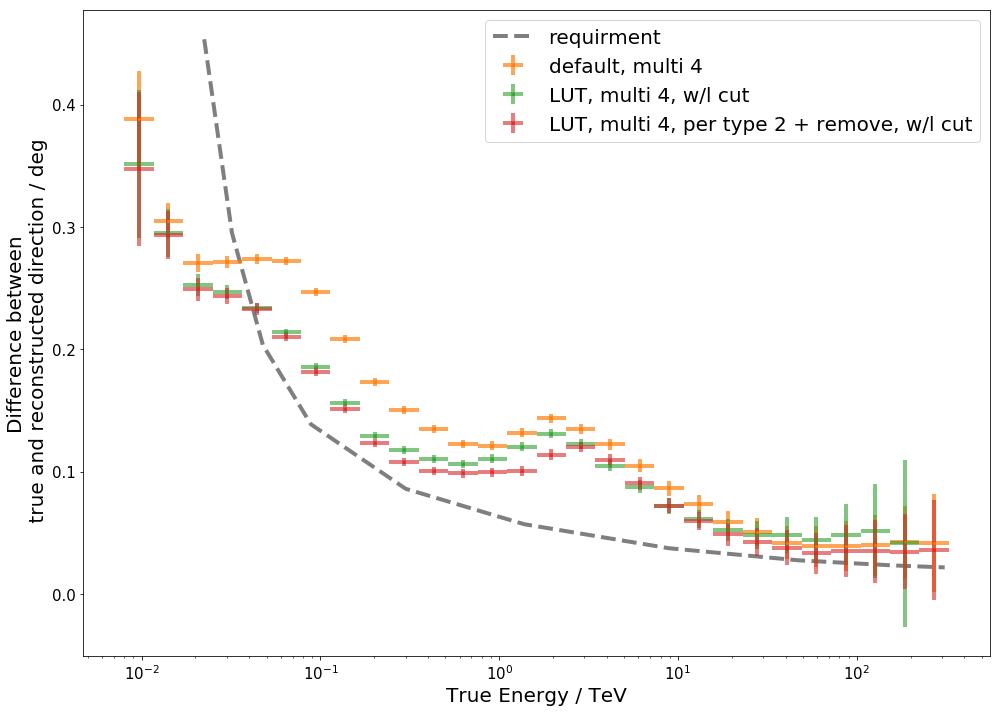

In [10]:
quantiles_default, pos, err_default = calc_angular_resolution(off_angle=data_default.off_angle,
                                  trueE=data_default.MC_Energy, erange=[0.008, 700], bins=30)

quantiles_LUT, pos, err_LUT = calc_angular_resolution(off_angle=data_LUT.off_angle,
                                  trueE=data_LUT.MC_Energy, erange=[0.008, 700], bins=30)

quantiles_LUT_ratiocut, pos, err_LUT_ratiocut = calc_angular_resolution(off_angle=data_LUT_ratiocut.off_angle,
                                  trueE=data_LUT_ratiocut.MC_Energy, erange=[0.008, 700], bins=30)

quantiles_LUT_ratiocut_pertype, pos, err_LUT_ratiocut_pertype = calc_angular_resolution(off_angle=data_LUT_ratiocut_pertype.off_angle,
                                  trueE=data_LUT_ratiocut_pertype.MC_Energy, erange=[0.008, 700], bins=30)


plt.figure(figsize=(14,10))
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15
plt.xscale('log')
#plt.ylim([0,.5])
plt.errorbar(pos, quantiles_default[0], quantiles_default[1], err_default, fmt="o", color="C1", zorder=10,
             label="default, multi 4", linewidth=4, markersize=2, alpha=0.7)
#plt.errorbar(pos, quantiles_LUT[0], quantiles_LUT[1], err_LUT, fmt="o", color="C0", zorder=10,
#             label="LUT, multi 4 ", linewidth=4, markersize=2, alpha=0.7)
plt.errorbar(pos, quantiles_LUT_ratiocut[0], quantiles_LUT_ratiocut[1], err_LUT_ratiocut, fmt="o", color="C2", zorder=10,
             label="LUT, multi 4, w/l cut", linewidth=4, markersize=2, alpha=0.6)
plt.errorbar(pos, quantiles_LUT_ratiocut_pertype[0], quantiles_LUT_ratiocut_pertype[1], err_LUT_ratiocut_pertype, fmt="o", color="C3", zorder=10,
             label="LUT, multi 4, per type 2 + remove, w/l cut", linewidth=4, markersize=2, alpha=0.6)

plt.plot(e, angres, linewidth=4, label="requirment", color="k", alpha=0.5, linestyle="--")
plt.xlabel("True Energy / TeV", fontsize=20)
plt.ylabel("Difference between\n true and reconstructed direction / deg", fontsize=20)

plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig("Standardarray_default_vs_LUT.pdf")

# Comparison of different multiplicity cuts

In [11]:
max_files = 500

#### default weights, cut on ratio width / length, $N_{images} > 4$, cut per type 2 (SST 3) keep all if one passed

In [12]:
datadir_def_keep = os.path.abspath("{}Multiplicity4_perType/defaultWeights_ratiocut_keepTypes_SST3_0801".format(output_dir))

data_def_keep = None
for file in glob.glob("{}/output*gamma*".format(datadir_def_keep))[:max_files]:
    datafile = pd.read_hdf(file, key="direction_reconstriction")
    try:
        data_def_keep = pd.concat([data_def_keep, datafile])
    except NameError:
        data_def_keep = datafile
    except (HDF5ExtError, OSError):
        print("Not able to read {}".format(file))
        continue

#### default weights, cut on ratio width / length, $N_{images} > 4$, cut per type 2 (SST 3) remove types

In [13]:
datadir_def_remove = os.path.abspath("{}/Multiplicity4_perType/defaultWeights_ratiocut_removedTypes_SST3_0801".format(output_dir))

data_def_remove = None
for file in glob.glob("{}/output*gamma*".format(datadir_def_remove))[:max_files]:
    datafile = pd.read_hdf(file, key="direction_reconstriction")
    try:
        data_def_remove = pd.concat([data_def_remove, datafile])
    except NameError:
        data_def_remove = datafile
    except (HDF5ExtError, OSError):
        print("Not able to read {}".format(file))
        continue

#### LUT weights, cut on ratio width / length, $N_{images} > 4$, cut per type 2 (SST 3) keep all if one passed

In [14]:
datadir_LUT_keep = os.path.abspath("{}Multiplicity4_perType/LUT_weights_ratiocut_keepTypes_SST3_0801".format(output_dir))

data_LUT_keep = None
for file in glob.glob("{}/output*gamma*".format(datadir_LUT_keep))[:max_files]:
    datafile = pd.read_hdf(file, key="direction_reconstriction")
    try:
        data_LUT_keep = pd.concat([data_LUT_keep, datafile])
    except NameError:
        data_LUT_keep = datafile
    except (HDF5ExtError, OSError):
        print("Not able to read {}".format(file))
        continue

#### LUT weights, cut on ratio width / length, $N_{images} > 4$, cut per type 2 (SST 3) remove types

In [15]:
datadir_LUT_remove = os.path.abspath("{}Multiplicity4_perType/LUT_weights_ratiocut_removedTypes_SST3_0801".format(output_dir))

data_LUT_remove = None
for file in glob.glob("{}/output*gamma*".format(datadir_LUT_remove))[:max_files]:
    datafile = pd.read_hdf(file, key="direction_reconstriction")
    try:
        data_LUT_remove = pd.concat([data_LUT_remove, datafile])
    except NameError:
        data_LUT_remove = datafile
    except (HDF5ExtError, OSError):
        print("Not able to read {}".format(file))
        continue

/Users/konstantinpfrang/anaconda3/envs/cta-dev/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


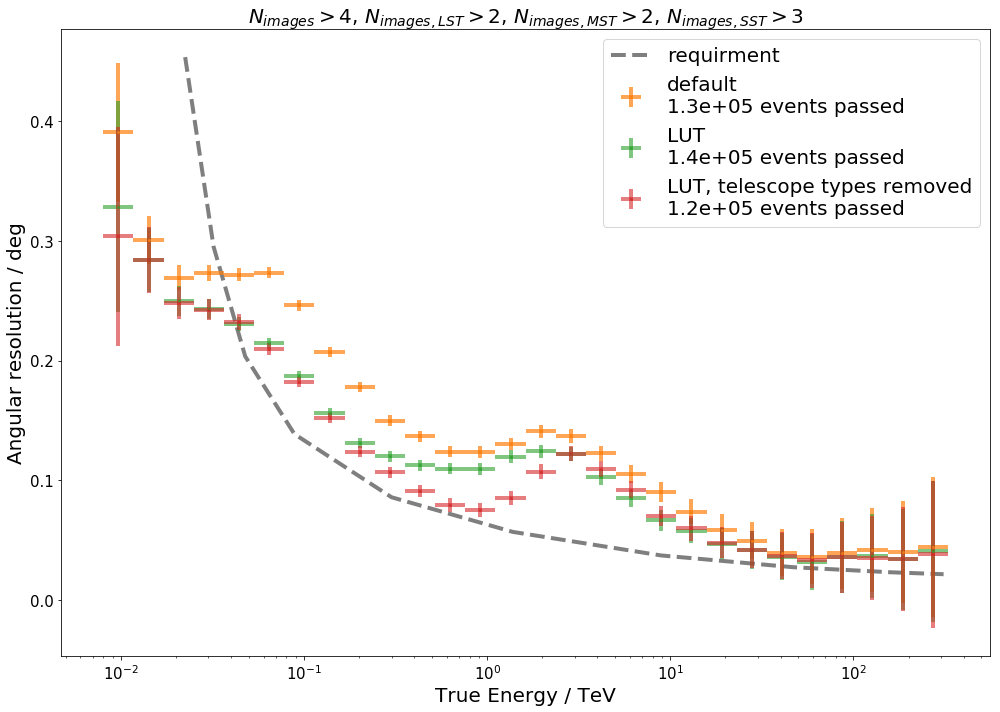

In [16]:
q_default_keep, pos, err_default_keep = calc_angular_resolution(off_angle=data_def_keep.off_angle,
                                  trueE=data_def_keep.MC_Energy, erange=[0.008, 700], bins=30)

q_default_remove, pos, err_default_remove = calc_angular_resolution(off_angle=data_def_remove.off_angle,
                                  trueE=data_def_remove.MC_Energy, erange=[0.008, 700], bins=30)

q_LUT_keep, pos, err_LUT_keep = calc_angular_resolution(off_angle=data_LUT_keep.off_angle,
                                  trueE=data_LUT_keep.MC_Energy, erange=[0.008, 700], bins=30)

q_LUT_remove, pos, err_LUT_remove = calc_angular_resolution(off_angle=data_LUT_remove.off_angle,
                                  trueE=data_LUT_remove.MC_Energy, erange=[0.008, 700], bins=30)


plt.figure(figsize=(14,10))
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15
plt.xscale('log')
#plt.ylim([0,.5])
plt.errorbar(pos, q_default_keep[0], q_default_keep[1], err_default_keep, fmt="o", color="C1", zorder=10,
             label="default\n{:1.1e} events passed".format(len(data_def_keep)), linewidth=4, markersize=2, alpha=0.7)
#plt.errorbar(pos, q_default_remove[0], q_default_remove[1], err_default_remove, fmt="o", color="C0", zorder=10,
#             label="default weights remove types ", linewidth=4, markersize=2, alpha=0.7)
plt.errorbar(pos, q_LUT_keep[0], q_LUT_keep[1], err_LUT_keep, fmt="o", color="C2", zorder=10,
             label="LUT\n{:1.1e} events passed".format(len(data_LUT_keep)), linewidth=4, markersize=2, alpha=0.6)
plt.errorbar(pos, q_LUT_remove[0], q_LUT_remove[1], err_LUT_remove, fmt="o", color="C3", zorder=10,
             label="LUT, telescope types removed\n{:1.1e} events passed".format(len(data_LUT_remove)), linewidth=4, markersize=2, alpha=0.6)

plt.plot(e, angres, linewidth=4, label="requirment", color="k", alpha=0.5, linestyle="--")
plt.xlabel("True Energy / TeV", fontsize=20)
plt.ylabel("Angular resolution / deg", fontsize=20)
plt.title(r"$N_{images}>4$, $N_{images, LST}>2$, $N_{images, MST}>2$, $N_{images, SST}>3$", fontsize=20)
plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig("Standardarray_def_LUT_removed_telescopes.pdf")

# Comparison of different multiplicity cuts SST4

In [17]:
max_files = 500

#### default weights, cut on ratio width / length, $N_{images} > 4$, cut per type 2 (SST 4) keep all if one passed

In [18]:
datadir_def_keep = os.path.abspath("{}Multiplicity4_perType/SST4/default_keep".format(output_dir))

data_def_keep = None
for file in glob.glob("{}/output*gamma*".format(datadir_def_keep))[:max_files]:
    datafile = pd.read_hdf(file, key="direction_reconstriction")
    try:
        data_def_keep = pd.concat([data_def_keep, datafile])
    except NameError:
        data_def_keep = datafile
    except (HDF5ExtError, OSError):
        print("Not able to read {}".format(file))
        continue

#### default weights, cut on ratio width / length, $N_{images} > 4$, cut per type 2 (SST 4) remove types

In [19]:
datadir_def_remove = os.path.abspath("{}Multiplicity4_perType/SST4/default_removed".format(output_dir))

data_def_remove = None
for file in glob.glob("{}/output*gamma*".format(datadir_def_remove))[:max_files]:
    datafile = pd.read_hdf(file, key="direction_reconstriction")
    try:
        data_def_remove = pd.concat([data_def_remove, datafile])
    except NameError:
        data_def_remove = datafile
    except (HDF5ExtError, OSError):
        print("Not able to read {}".format(file))
        continue

#### LUT weights, cut on ratio width / length, $N_{images} > 4$, cut per type 2 (SST 4) keep all if one passed

In [20]:
datadir_LUT_keep = os.path.abspath("{}Multiplicity4_perType/SST4/LUT_keep".format(output_dir))

data_LUT_keep = None
for file in glob.glob("{}/output*gamma*".format(datadir_LUT_keep))[:max_files]:
    datafile = pd.read_hdf(file, key="direction_reconstriction")
    try:
        data_LUT_keep = pd.concat([data_LUT_keep, datafile])
    except NameError:
        data_LUT_keep = datafile
    except (HDF5ExtError, OSError):
        print("Not able to read {}".format(file))
        continue

#### LUT weights, cut on ratio width / length, $N_{images} > 4$, cut per type 2 (SST 4) remove types

In [21]:
datadir_LUT_remove = os.path.abspath("{}Multiplicity4_perType/SST4/LUT_remove".format(output_dir))

data_LUT_remove = None
for file in glob.glob("{}/output*gamma*".format(datadir_LUT_remove))[:max_files]:
    datafile = pd.read_hdf(file, key="direction_reconstriction")
    try:
        data_LUT_remove = pd.concat([data_LUT_remove, datafile])
    except NameError:
        data_LUT_remove = datafile
    except (HDF5ExtError, OSError):
        print("Not able to read {}".format(file))
        continue

/Users/konstantinpfrang/anaconda3/envs/cta-dev/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


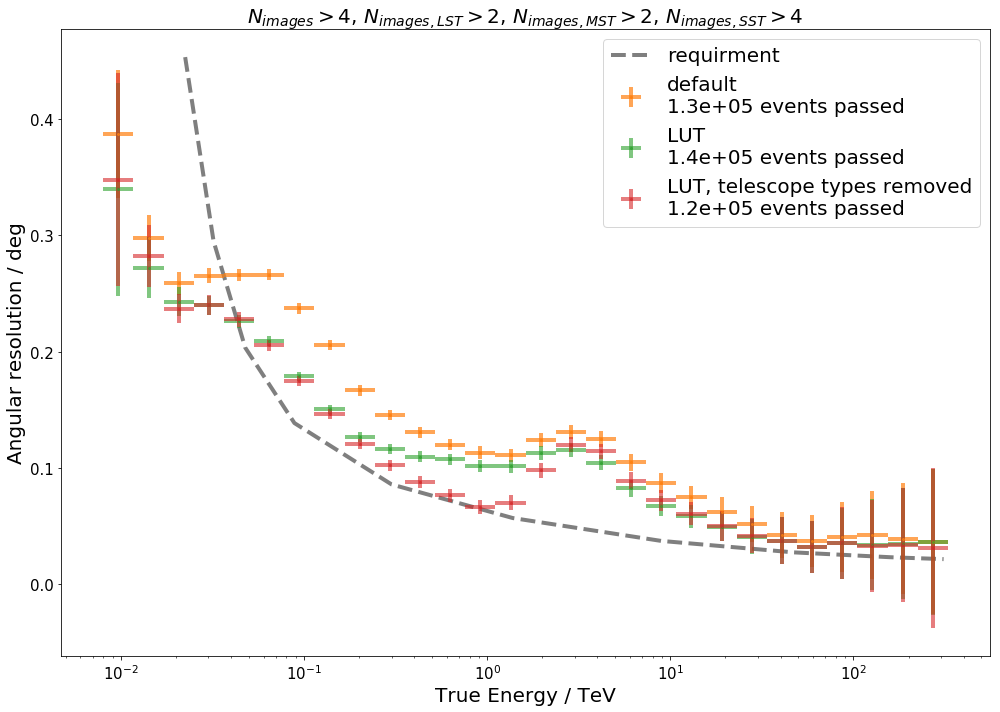

In [22]:
q_default_keep, pos, err_default_keep = calc_angular_resolution(off_angle=data_def_keep.off_angle,
                                  trueE=data_def_keep.MC_Energy, erange=[0.008, 700], bins=30)

q_default_remove, pos, err_default_remove = calc_angular_resolution(off_angle=data_def_remove.off_angle,
                                  trueE=data_def_remove.MC_Energy, erange=[0.008, 700], bins=30)

q_LUT_keep, pos, err_LUT_keep = calc_angular_resolution(off_angle=data_LUT_keep.off_angle,
                                  trueE=data_LUT_keep.MC_Energy, erange=[0.008, 700], bins=30)

q_LUT_remove, pos, err_LUT_remove = calc_angular_resolution(off_angle=data_LUT_remove.off_angle,
                                  trueE=data_LUT_remove.MC_Energy, erange=[0.008, 700], bins=30)


plt.figure(figsize=(14,10))
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15
plt.xscale('log')
#plt.ylim([0,.5])
plt.errorbar(pos, q_default_keep[0], q_default_keep[1], err_default_keep, fmt="o", color="C1", zorder=10,
             label="default\n{:1.1e} events passed".format(len(data_def_keep)), linewidth=4, markersize=2, alpha=0.7)
#plt.errorbar(pos, q_default_remove[0], q_default_remove[1], err_default_remove, fmt="o", color="C0", zorder=10,
#             label="default weights remove types ", linewidth=4, markersize=2, alpha=0.7)
plt.errorbar(pos, q_LUT_keep[0], q_LUT_keep[1], err_LUT_keep, fmt="o", color="C2", zorder=10,
             label="LUT\n{:1.1e} events passed".format(len(data_LUT_keep)), linewidth=4, markersize=2, alpha=0.6)
plt.errorbar(pos, q_LUT_remove[0], q_LUT_remove[1], err_LUT_remove, fmt="o", color="C3", zorder=10,
             label="LUT, telescope types removed\n{:1.1e} events passed".format(len(data_LUT_remove)), linewidth=4, markersize=2, alpha=0.6)

plt.plot(e, angres, linewidth=4, label="requirment", color="k", alpha=0.5, linestyle="--")
plt.xlabel("True Energy / TeV", fontsize=20)
plt.ylabel("Angular resolution / deg", fontsize=20)
plt.title(r"$N_{images}>4$, $N_{images, LST}>2$, $N_{images, MST}>2$, $N_{images, SST}>4$", fontsize=20)
plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig("Standardarray_def_LUT_removed_telescopes_SST4.pdf")

/Users/konstantinpfrang/anaconda3/envs/cta-dev/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


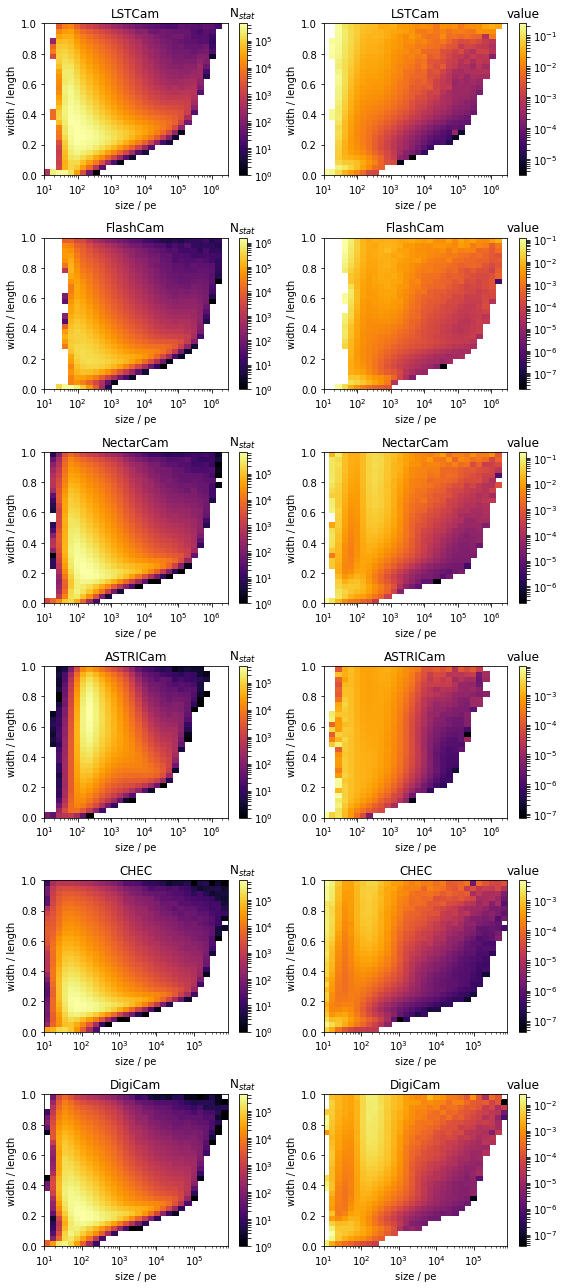

In [40]:
LUTgen = LookupGenerator.load("../../scripts/write_feature_list/ctapipe_aux_dir/direction_weights_LUT_all.json")
LUTgen.display_lookup(xlabel="size / pe", ylabel="width / length")

# Playground

## Analyze one file

In [29]:
from ctapipe.coordinates import CameraFrame, HorizonFrame
from astropy.coordinates import SkyCoord

from ctapipe.visualization import CameraDisplay   # plot camera images
from ctapipe.io import event_source               # read rata
from ctapipe.calib import CameraCalibrator        # calibration from r0 to dl1
from ctapipe.calib.camera.gainselection import pick_gain_channel # gain selection
from ctapipe.image.cleaning import tailcuts_clean # image cleaning
from ctapipe.image import hillas_parameters       # parametrization
from traitlets.config import Config               # handeling of configurations
from ctapipe.io import EventSeeker
import pickle

# Ecample: make the LUT

In [31]:
source = event_source("/Users/konstantinpfrang/CTAPIPE/gamma_onSource/\
gamma_20deg_180deg_run1___cta-prod3_desert-2150m-Paranal-merged.simtel.gz",
                     max_events=20)

In [37]:
event = next(iter(source))
event.inst.subarray.tel[1].camera.cam_id

'LSTCam'

# Diffuse LUT in offsetbins

/Users/konstantinpfrang/anaconda3/envs/cta-dev/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


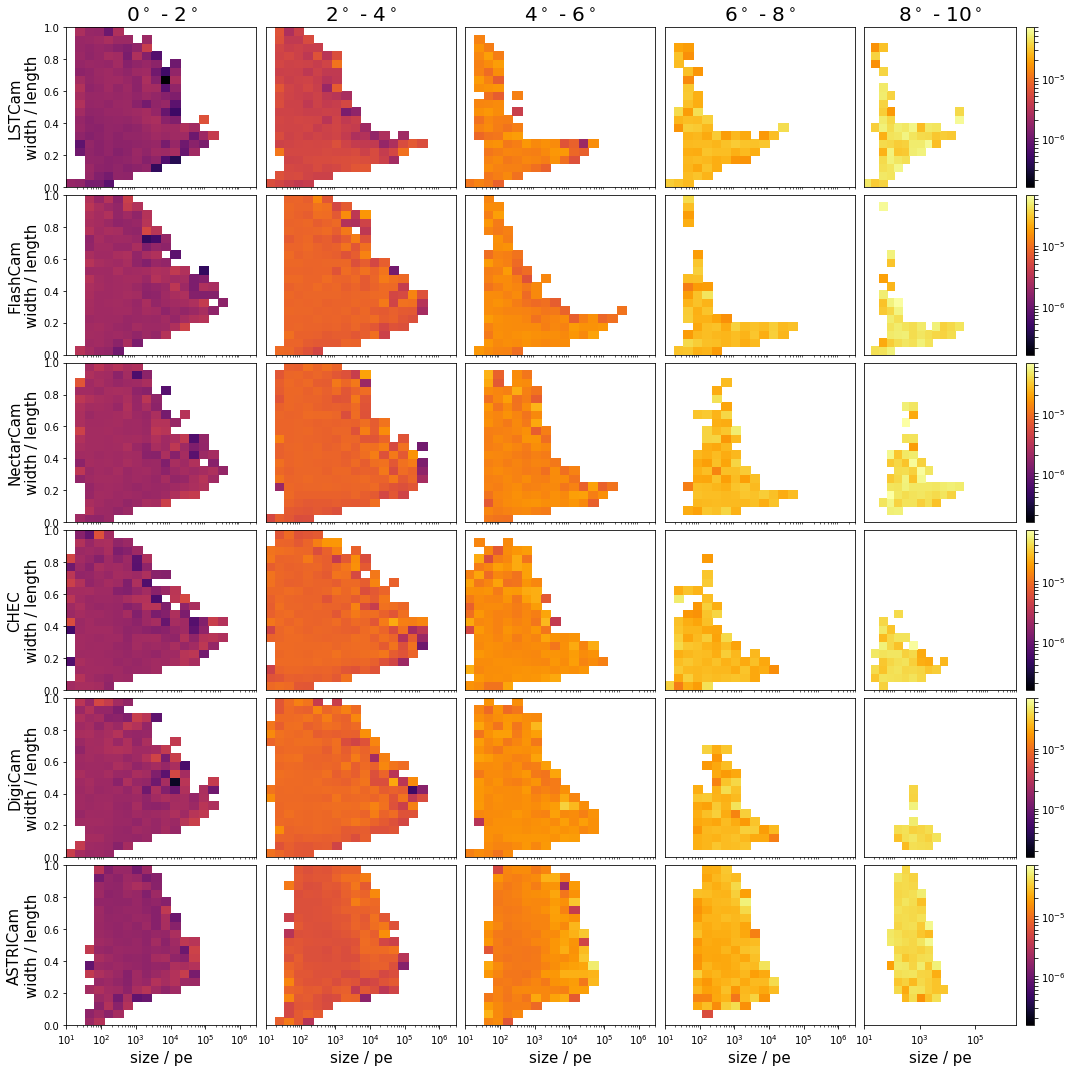

In [28]:
files = glob.glob("/Users/konstantinpfrang/ctaout/diffuse/make_LUT/LUT_500_verbose_deg/output*.pickle")
LUTs = merge_verbose_LUTs(files, 5)

max_val, min_val = get_vrange(LUTs)
plot_verbose(LUTs)
plt.savefig("LUT_offsets_deg.pdf")

/Users/konstantinpfrang/anaconda3/envs/cta-dev/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


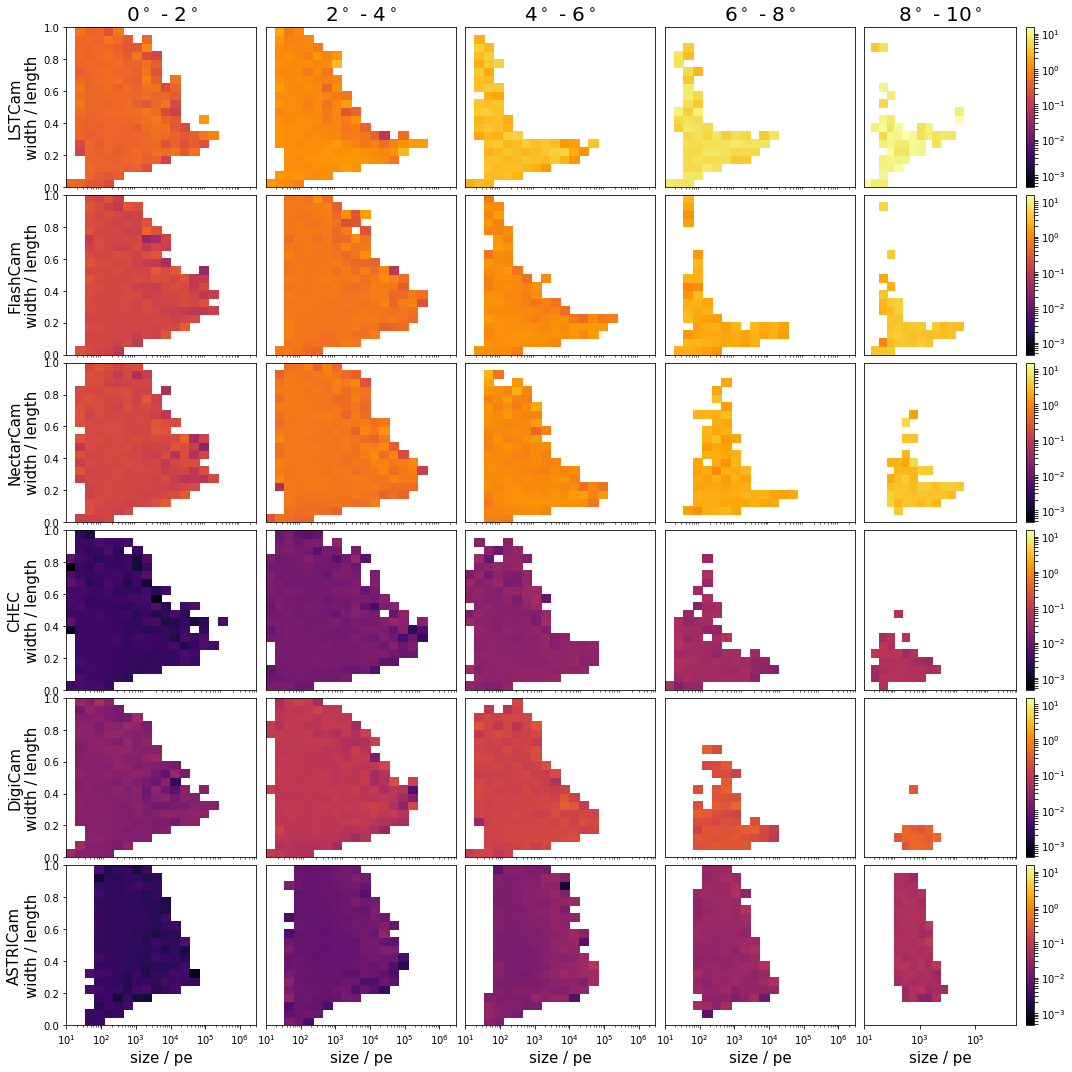

In [27]:
files = glob.glob("/Users/konstantinpfrang/ctaout/diffuse/make_LUT/LUT_500_verbose/output*.pickle")
LUTs = merge_verbose_LUTs(files, 5)
max_val, min_val = get_vrange(LUTs)
plot_verbose(LUTs)
plt.savefig("LUT_offsets_m.pdf")

/Users/konstantinpfrang/anaconda3/envs/cta-dev/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


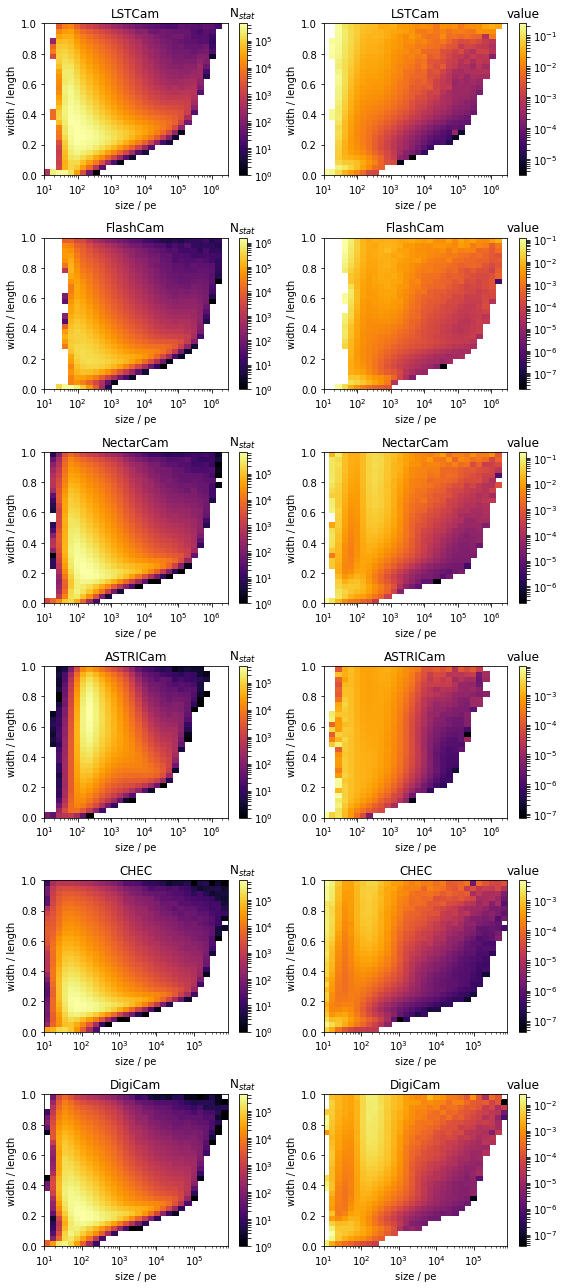

In [41]:
LUTgen = LookupGenerator.load("../../scripts/write_feature_list/ctapipe_aux_dir/direction_weights_LUT_all.json")
LUTgen.display_lookup(xlabel="size / pe", ylabel="width / length")

/Users/konstantinpfrang/anaconda3/envs/cta-dev/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


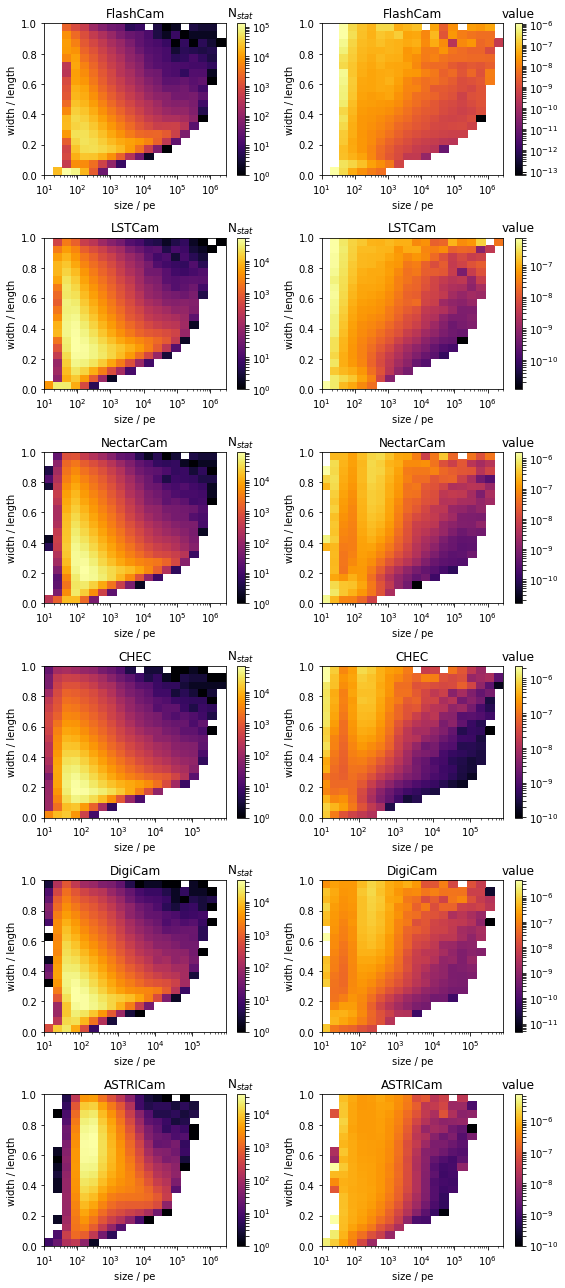

In [47]:
LUTdeg = LookupGenerator.load("../../scripts/write_feature_list/ctapipe_aux_dir/direction_weights_LUT_deg.json")
LUTdeg.display_lookup(xlabel="size / pe", ylabel="width / length")

In [89]:
from ctapipe.io.containers import HillasParametersContainer

In [53]:
maxvals = []
minvals = []

for a in np.array(list(LUTdeg.lookup.values()))[:,3]:
    maxvals.append(np.max(a[~np.isnan(a)]))
    minvals.append(np.min(a[~np.isnan(a)]))
minval = np.min(minvals)
maxval = np.max(maxvals)

/Users/konstantinpfrang/anaconda3/envs/cta-dev/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


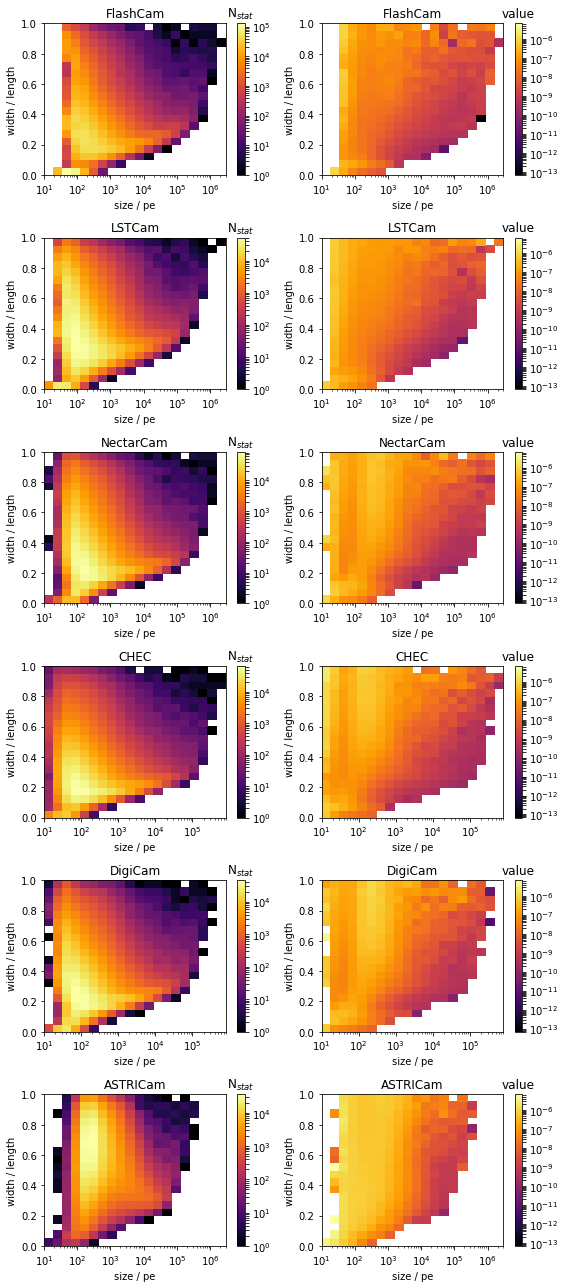

In [55]:
LUTdeg = LookupGenerator.load("../../scripts/write_feature_list/ctapipe_aux_dir/direction_weights_LUT_deg.json")
LUTdeg.display_lookup(xlabel="size / pe", ylabel="width / length", vmin=minval, vmax=maxval)

In [26]:
#del dca_list

files = glob.glob("/Users/konstantinpfrang/ctaout/diffuse/make_LUT/LUT_10_dcalist/output*.h5")

for file in files:
    try:
        dca_list = dca_list.append(pd.read_hdf(file, "/dca_list"))
    except NameError:
        dca_list = pd.read_hdf(file, "/dca_list")
dca_list = dca_list.reset_index(drop=True)

In [27]:

dca_list.loc[:, "ratio"] = dca_list.width / dca_list.length
dca_list = dca_list[np.isfinite(dca_list).all(axis=1)]


In [48]:
files = glob.glob("/Users/konstantinpfrang/ctaout/diffuse/make_LUT/LUT_10_dcalist/output*.h5")
LUTGen = LookupGenerator.load_data_from_files(files)

In [49]:
for cam in LUTGen.data:
    print(LUTGen.data[cam].shape)

(2174, 3)
(4893, 3)
(6237, 3)
(4389, 3)
(4264, 3)
(4315, 3)


In [83]:
files = glob.glob("/Users/konstantinpfrang/ctaout/point/make_LUT/LUT_all_dcalist/output*.h5")

LUTGen = LookupGenerator.load_data_from_files(files)

KeyboardInterrupt: 

In [ ]:
LUTGen.make